<a href="https://colab.research.google.com/github/KaiXiangC/Python_Factor-Investing_Final-Project/blob/main/D1087839_%E7%8E%8B%E4%BF%8A%E5%8B%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 期末報告範例

- 以`台股上市櫃公司`為標的，只要有用到`AI模型(機器學習或深度學習)`，且有使用到`股票因子`作為輸入資料，產出`月換倉的投資組合`即可，其餘設定皆可自由調整。
- 投組績效計算期間為 `2022/01~2023/11`，對應大盤Benchmark為`台灣加權報酬指數`。
- 績效數字只是期末報告評分的參考之一，我們更重視報告的`邏輯架構和完整性` !


# 1.0 安裝套件 & 環境

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import MonthEnd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import xgboost #機器學習套件

plt.style.use('ggplot')
plt.rcParams.update({
    'font.weight': 'bold',
    'text.color': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k'})
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.0 股票因子計算

- 計算因子前，先檢查該欄位重複值、缺失值情況，並予以處理。若缺失值過多，會影響後續資料筆數和模型訓練。
- 根據課堂所學或其他方式，製作各類因子。
- 思考各因子背後的經濟邏輯，為何能透過其預測未來股價，並在報告時一併說明
- 這部份是投組績效最大的差異來源，也是期末報告評分佔比最大的一部份歐，大家加油 !

## 2.1 價量因子

In [3]:
# 讀入台股價量資料
df_price = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df_price.head()

,證券名稱,資料日,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
0,1101台泥,2018-01-02,TWSE,36.45,36.60,36.05,20.444681,13698.0,499370945.0,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
1,1102亞泥,2018-01-02,TWSE,28.30,28.40,28.05,19.734614,6669.0,187956859.0,2492.0,0.1984,3361447.0,9.479281e+10,0.296421,0.196,3.19,19.28,0.75,1.52
2,1103嘉泥,2018-01-02,TWSE,13.35,13.45,13.15,10.054507,1007.0,13406478.0,346.0,0.1300,774781.0,1.042080e+10,0.032586,0.014,1.49,173.87,0.61,4.01
3,1104環泥,2018-01-02,TWSE,23.00,23.05,22.90,16.405601,344.0,7919719.0,184.0,0.0526,653609.0,1.503301e+10,0.047009,0.008,5.07,10.07,0.93,3.31
4,1108幸福,2018-01-02,TWSE,8.35,8.40,8.35,7.062476,95.0,799475.0,51.0,0.0235,404738.0,3.399799e+09,0.010631,0.001,7.14,52.41,0.75,0.92


In [4]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338403 entries, 0 to 2338402
Data columns (total 19 columns):
 #   Column      Dtype         
---  ------      -----         
 0   證券名稱        object        
 1   資料日         datetime64[ns]
 2   市場別         object        
 3   開盤價         float64       
 4   最高價         float64       
 5   最低價         float64       
 6   收盤價         float64       
 7   成交量(千股)     float64       
 8   成交金額(元)     float64       
 9   成交筆數        float64       
 10  周轉率         float64       
 11  流通在外股數(千股)  float64       
 12  個股市值(元)     float64       
 13  市值比重        float64       
 14  成交金額比重      float64       
 15  現金股利率(TEJ)  float64       
 16  本益比(TEJ)    float64       
 17  股價淨值比(TEJ)  float64       
 18  股價營收比(TEJ)  float64       
dtypes: datetime64[ns](1), float64(16), object(2)
memory usage: 339.0+ MB


In [5]:
df_price.columns

Index(['證券名稱', '資料日', '市場別', '開盤價', '最高價', '最低價', '收盤價', '成交量(千股)', '成交金額(元)',
       '成交筆數', '周轉率', '流通在外股數(千股)', '個股市值(元)', '市值比重', '成交金額比重', '現金股利率(TEJ)',
       '本益比(TEJ)', '股價淨值比(TEJ)', '股價營收比(TEJ)'],
      dtype='object')

In [6]:
result= df_price.groupby('證券名稱')['現金股利率(TEJ)'].mean()
df_price['資料日'] = pd.to_datetime(df_price['資料日'])
df_price['近一年現金股利率(TEJ)平均'] = df_price.groupby(['證券名稱',df_price['資料日'].dt.year])['現金股利率(TEJ)'].transform('mean')
df_price['近一年市值平均'] = df_price.groupby(['證券名稱',df_price['資料日'].dt.year])['個股市值(元)'].transform('mean')
df_price['5日歷史報酬'] = df_price.groupby('證券名稱').apply(lambda x:x['收盤價'] / x['收盤價'].shift(5) - 1).reset_index(level=0,drop=True)
df_price[df_price['證券名稱'] == '6148驊宏資'][['證券名稱','資料日','近一年現金股利率(TEJ)平均']].head(600)

,證券名稱,資料日,近一年現金股利率(TEJ)平均
1175,6148驊宏資,2018-01-02,0.000000
2722,6148驊宏資,2018-01-03,0.000000
4270,6148驊宏資,2018-01-04,0.000000
5819,6148驊宏資,2018-01-05,0.000000
7368,6148驊宏資,2018-01-08,0.000000
...,...,...,...
944484,6148驊宏資,2020-06-15,3.754896
946089,6148驊宏資,2020-06-16,3.754896
947694,6148驊宏資,2020-06-17,3.754896
949299,6148驊宏資,2020-06-18,3.754896


##2.2-1 Momentum Indicator 趨勢指標因子

In [7]:
# For Ta-Lib
!pip install numpy==1.23.0 --force
!pip install yfinance
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
#!pip install mpl_finance
!pip install mglearn
#!pip install --upgrade mplfinance

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.


(Reading database ... 121680 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link



In [8]:
# 匯入需要的套件

#from scipy.stats import skew
# 儲存模型
from pickle import dump
# 擷取yahoo finance資料套件
import yfinance as yf
#----------------------機器學習套件-------------------#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
# 計算技術指標套件
import talib

In [9]:
# 從"市場別"列中獲取不重複的值
unique_market = df_price['證券名稱'].unique()

# 輸出不重複的市場別值
print(unique_market)

['1101台泥' '1102亞泥' '1103嘉泥' ... '2258鴻華先進-創' '5292華懋' '6894衛司特']


In [10]:
# 創建空串列來存放數字和公司名稱
stock_ids = []

# 逐一處理獨特的證券名稱
for security in unique_market:
    # 從證券名稱中分離數字和公司名稱
    num = ''.join(filter(str.isdigit, security))  # 提取數字部分

    # 將數字加入串列中
    stock_ids.append(num)

# 顯示結果
print("數字部分：", stock_ids)
print("數字的總數：", len(stock_ids))

數字部分： ['1101', '1102', '1103', '1104', '1108', '1109', '1110', '1201', '1203', '1210', '1213', '1215', '1216', '1217', '1218', '1219', '1220', '1225', '1227', '1229', '1231', '1232', '1233', '1234', '1235', '1236', '1259', '1264', '1268', '1301', '1303', '1304', '1305', '1307', '1308', '1309', '1310', '1312', '1313', '1314', '1315', '1316', '1319', '1321', '1323', '1324', '1325', '1326', '1333', '1336', '1339', '1402', '1409', '1410', '1413', '1414', '1416', '1417', '1418', '1419', '1423', '1432', '1434', '1435', '1436', '1437', '1438', '1439', '1440', '1441', '1442', '1443', '1444', '1445', '1446', '1447', '1449', '1451', '1452', '1453', '1454', '1455', '1456', '1457', '1459', '1460', '1463', '1464', '1465', '1466', '1467', '1468', '1469', '1470', '1471', '1472', '1473', '1474', '1475', '1476', '1477', '1503', '1504', '1506', '1507', '1512', '1513', '1514', '1515', '1516', '1517', '1519', '1521', '1522', '1524', '1525', '1526', '1527', '1528', '1529', '1530', '1531', '1532', '1533', '

In [11]:
# 創建一個空字典來存放股票代碼和名稱的對應關係
stock_dict = {}

# 透過迴圈將股票代碼和名稱映射成字典
for i in range(len(stock_ids)):
    stock_dict[stock_ids[i]] = unique_market[i]

stock_dict = {key: ''.join(filter(str.isalpha, value)) for key, value in stock_dict.items()}

print(stock_dict)
# 顯示字典內容
#print("股票代碼和名稱的對應字典：", stock_dict)

{'1101': '台泥', '1102': '亞泥', '1103': '嘉泥', '1104': '環泥', '1108': '幸福', '1109': '信大', '1110': '東泥', '1201': '味全', '1203': '味王', '1210': '大成', '1213': '大飲', '1215': '卜蜂', '1216': '統一', '1217': '愛之味', '1218': '泰山', '1219': '福壽', '1220': '台榮', '1225': '福懋油', '1227': '佳格', '1229': '聯華', '1231': '聯華食', '1232': '大統益', '1233': '天仁', '1234': '黑松', '1235': '興泰', '1236': '宏亞', '1259': '安心', '1264': '德麥', '1268': '漢來美食', '1301': '台塑', '1303': '南亞', '1304': '台聚', '1305': '華夏', '1307': '三芳', '1308': '亞聚', '1309': '台達化', '1310': '台苯', '1312': '國喬', '1313': '聯成', '1314': '中石化', '1315': '達新', '1316': '上曜', '1319': '東陽', '1321': '大洋', '1323': '永裕', '1324': '地球', '1325': '恒大', '1326': '台化', '1333': '恩得利', '1336': '台翰', '1339': '昭輝', '1402': '遠東新', '1409': '新纖', '1410': '南染', '1413': '宏洲', '1414': '東和', '1416': '廣豐', '1417': '嘉裕', '1418': '東華', '1419': '新紡', '1423': '利華', '1432': '大魯閣', '1434': '福懋', '1435': '中福', '1436': '華友聯', '1437': '勤益控', '1438': '三地開發', '1439': '雋揚', '1440': '南紡', '1441': '大東', '144

In [12]:
# 要預測 NextPeriod 日後的報酬
NextPeriod = 1
# 下載近五年日資料並合併為一個 DataFrame
dfs = []

# 計算無法下載的股票代號數量
unavailable_stocks = 0
available_stocks = 0

for stock_id in stock_ids:
    try:
      data = yf.download(stock_id+'.TW',start='2018-01-02', end='2023-11-30', interval='1d')
      data['stock_id'] = stock_id# 添加股票代號作為欄位
      dfs.append(data)
      available_stocks += 1
    except:
      unavailable_stocks += 1
      continue

print(f"無法下載的股票代號數量：{unavailable_stocks}")
print(f"已下載的股票代號數量：{available_stocks}")
# 在此之後可以繼續處理 dfs 中的資料，包括合併、分析等

# 將所有資料框架合併為一個 DataFrame
data = pd.concat(dfs)
data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1259.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1264.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1268.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1333.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1336.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1507.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1565.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1566.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1569.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1570.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1580.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1584.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1586.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1593.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1595.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1599.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1724.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1742.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1777.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1781.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1784.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1785.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1787.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1788.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1799.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1813.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1815.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1902.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2035.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2061.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2063.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2064.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2065.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2066.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2067.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2221.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2230.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2230.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2235.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2311.TW']: No price data found, symbol may be delisted (1d 2018-01-02 -> 2023-11-30)



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2311.TW']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-02 -> 2023-11-30)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2448.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2456.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2475.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2499.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2596.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2640.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2641.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2643.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2718.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2719.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2729.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2732.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2734.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2736.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2740.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2823.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2841.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2916.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2926.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2937.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3064.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3066.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3067.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3068.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3071.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3073.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3078.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3081.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3083.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3085.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3086.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3088.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3089.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3093.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3095.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3105.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3114.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3115.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3118.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3122.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3128.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3131.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3141.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3144.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3152.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3162.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3163.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3169.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3171.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3176.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3188.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3191.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3202.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3202.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['3205.TW', '3206.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3207.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3211.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3213.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3217.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3218.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3219.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3221.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3224.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3226.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3227.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3228.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3230.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3232.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3234.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3236.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3252.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3259.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3260.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3264.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3265.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3268.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3272.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3276.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3284.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3285.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3287.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3288.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3289.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3290.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3293.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3294.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3297.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3299.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3303.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3306.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3310.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3313.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3317.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3322.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3323.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3324.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3325.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3332.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3339.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3339.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3354.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3360.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3362.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3363.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3372.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3373.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3374.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3379.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3383.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3388.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3390.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3402.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3426.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3428.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3431.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3434.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3438.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3441.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3444.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3452.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3455.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3465.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3466.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3479.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3483.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3484.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3489.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3490.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3491.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3492.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3498.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3499.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3508.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3511.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3512.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3516.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3519.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3520.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3521.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3522.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3523.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3526.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3527.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3529.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3531.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3536.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3537.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3540.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3541.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3546.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3548.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3551.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3552.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3555.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3556.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3558.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3562.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3564.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3567.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3570.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3577.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3579.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3580.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3581.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3587.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3594.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3609.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3611.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3615.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3623.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3624.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3625.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3628.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3629.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3630.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3631.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3632.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3642.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3646.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3663.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3666.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3672.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3675.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3680.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3684.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3685.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3687.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3689.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3691.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3693.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3698.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3707.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3709.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3710.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4102.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4103.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4105.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4107.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4109.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4111.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4113.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4114.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4116.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4120.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4121.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4123.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4126.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4127.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4128.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4129.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4130.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4131.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4138.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4147.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4152.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4153.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4160.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4161.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4162.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4163.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4167.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4168.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4171.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4173.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4174.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4175.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4180.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4183.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4188.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4192.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4198.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4205.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4207.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4303.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4304.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4305.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4401.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4402.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4406.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4413.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4415.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4416.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4417.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4419.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4420.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4429.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4430.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4432.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4433.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4502.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4503.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4506.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4510.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4510.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['4523.TW', '4513.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4527.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4527.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4528.TW', '4529.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4530.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4533.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4534.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4535.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4541.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4542.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4543.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4549.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4550.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4554.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4556.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4609.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4702.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4706.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4707.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4711.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4712.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4714.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4716.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4721.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4725.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4726.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4728.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4729.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4735.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4736.TW']: Exception("%ticker%: Data doesn't exist for startDate = 1514822400, endDate = 1701273600")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4741.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4743.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4747.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4754.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4806.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4903.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4905.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4907.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4908.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4909.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4911.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4933.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4939.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4944.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4946.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4950.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4953.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4965.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4972.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4973.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4974.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4974.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4979.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4987.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4995.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5009.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5011.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5013.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5014.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5015.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5016.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5102.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5201.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5202.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5205.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5206.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5209.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5210.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5211.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5212.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5213.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5230.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5245.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5251.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5255.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5259.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5263.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5272.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5274.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5278.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5287.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5289.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5291.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5301.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5302.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5304.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5305.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5309.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5310.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5312.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5314.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5315.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5317.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5321.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5324.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5328.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5340.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5344.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5345.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5347.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5348.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5349.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5349.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5351.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5353.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['5356.TW', '5355.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['5371.TW', '5364.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5381.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5383.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5386.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5392.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5398.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5403.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5410.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5425.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5426.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5432.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5438.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5439.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5443.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5450.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5452.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5455.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5457.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5460.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5464.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5465.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5468.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5474.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5475.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5478.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5480.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5481.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5483.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5487.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5488.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5489.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5490.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5493.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5498.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5508.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5511.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5512.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5514.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5516.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5520.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5523.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5529.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5530.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5530.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5536.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5601.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5603.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5604.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5609.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5701.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5703.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5704.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5820.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5878.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5902.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5903.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5904.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5905.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6015.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6016.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6020.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6021.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6023.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6026.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6101.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6103.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6104.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6109.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6111.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6113.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6114.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6118.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6121.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6122.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6123.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6124.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6125.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6126.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6127.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6129.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6130.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6131.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6134.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6138.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6140.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['6144.TW', '6143.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6145.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6146.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6147.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6148.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6150.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6151.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6154.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6156.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6158.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6160.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6161.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6163.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6167.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6169.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6170.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6171.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6172.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6173.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6174.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6175.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6179.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6180.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6182.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6185.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6186.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6187.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6188.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6190.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6194.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6195.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6198.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6199.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6203.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6204.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6207.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6208.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6210.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6212.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6217.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6218.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6219.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6220.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6221.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6222.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6223.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6227.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6228.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6229.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6231.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6233.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6234.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6236.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6237.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6238.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6240.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6241.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6242.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6244.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6245.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6245.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['6246.TW', '6247.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6248.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6251.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6259.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6261.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6263.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6264.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6265.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6266.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6270.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6274.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6275.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6276.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6279.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6284.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6287.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6289.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6290.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6291.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6292.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6294.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6298.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6411.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6417.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6419.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6432.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6435.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6441.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6441.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6446.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6457.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6462.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6465.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6469.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6470.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6472.TW']: Exception("%ticker%: Data doesn't exist for startDate = 1514822400, endDate = 1701273600")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6482.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6485.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6486.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6488.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6492.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6494.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6496.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6499.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6506.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6508.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6509.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6510.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6512.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6523.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6532.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6535.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6538.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6542.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6548.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6556.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6560.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6568.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6569.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6570.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6574.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6574.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6577.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['6594.TW', '6593.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6603.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6609.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6613.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6803.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['7402.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8024.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8027.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8032.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8034.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8038.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8040.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8042.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8043.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8044.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8047.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8048.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8049.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8050.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8054.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8059.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8064.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8067.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8066.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['8068.TW', '8069.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8071.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8074.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8076.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8077.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8080.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8083.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8084.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8085.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8086.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8087.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8088.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8091.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8092.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8093.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8096.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8097.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8099.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8107.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8109.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8111.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8121.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8147.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8155.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8171.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8176.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8182.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8183.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8234.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8240.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8255.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8277.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8279.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8287.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8289.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8291.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8299.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8299.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8342.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8349.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8354.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8358.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8383.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8390.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8401.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8403.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8409.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['8415.TW', '8410.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8416.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8420.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8421.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8424.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8431.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8432.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8433.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8435.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8436.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8446.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8450.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8472.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8477.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8489.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8905.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8906.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8908.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8913.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8916.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8917.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8921.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8923.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8924.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8927.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8928.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8929.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8930.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8931.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8932.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8933.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8934.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8935.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8936.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8937.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8938.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8941.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8942.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['9949.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['9950.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['9951.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['9960.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['9962.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6596.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1796.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6615.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5299.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6530.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8497.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6461.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8440.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5864.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2745.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6547.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5220.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3147.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6561.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4561.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6576.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4563.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4744.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6612.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1240.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6664.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6578.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4568.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6640.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6654.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4767.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6667.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3178.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2070.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6590.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4538.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6425.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['664331.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6418.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4760.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6662.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6683.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6516.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6679.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6624.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6649.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6589.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6680.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4931.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6642.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2752.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6690.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6527.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6697.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4580.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3713.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2743.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3597.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6716.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8284.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6732.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6588.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2754.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['8089.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6703.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['7556.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4945.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6727.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6752.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2755.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6762.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6728.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6751.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6712.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6747.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6767.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6767.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['6733.TW', '6661.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6651.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3357.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5236.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6684.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6788.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2947.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6761.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2756.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6693.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6829.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4923.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6763.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4558.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4558.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6804.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3349.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6721.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4768.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6735.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['5228.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6546.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4577.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6823.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6811.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['3430.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4584.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6855.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['4951.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6843.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['6843.TW', '6791.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6859.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6874.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['8227.TW', '6517.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6708.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6865.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6841.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6840.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6846.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6584.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6821.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6877.TW']: No timezone found, symbol may be delisted



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['2073.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6895.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6870.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6856.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6922.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6894.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



無法下載的股票代號數量：382
已下載的股票代號數量：1377


,Open,High,Low,Close,Adj Close,Volume,stock_id
Date,,,,,,,
2018-01-02,26.811218,26.921553,26.516994,26.884773,20.458881,18623790.0,1101
2018-01-03,26.847996,27.473225,26.664106,27.473225,20.906683,27135492.0,1101
2018-01-04,27.473225,27.546780,27.031887,27.362888,20.822720,20294319.0,1101
2018-01-05,27.583557,27.583557,27.252556,27.436445,20.878695,48312496.0,1101
2018-01-08,27.510002,28.172007,27.362888,28.098452,21.382471,30807321.0,1101


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1093115 entries, 2018-01-02 to 2023-11-29
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Open       1093115 non-null  float64
 1   High       1093115 non-null  float64
 2   Low        1093115 non-null  float64
 3   Close      1093115 non-null  float64
 4   Adj Close  1093115 non-null  float64
 5   Volume     1093115 non-null  float64
 6   stock_id   1093115 non-null  object 
dtypes: float64(6), object(1)
memory usage: 66.7+ MB


In [14]:
datta = data.copy()
# 使用map函數將股票代碼映射為公司名稱，並連結到Stock_ID列中
data['stock_id'] = data['stock_id'].astype(str) + data['stock_id'].map(stock_dict)

data.columns = ['Open','High','Low','Close','Adj Close','Volume','證券名稱']
data = data.reindex(columns=['證券名稱','Open','High','Low','Close','Adj Close','Volume'])

In [15]:
#將原先是索引的date轉成Column
data.reset_index(inplace=True)
data.columns = ["日期",'證券名稱','Open','High','Low','Close','Adj Close','Volume']

In [16]:
#將日期從float轉datetime
data["日期"] = pd.to_datetime(data["日期"], unit='D')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093115 entries, 0 to 1093114
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   日期         1093115 non-null  datetime64[ns]
 1   證券名稱       1093115 non-null  object        
 2   Open       1093115 non-null  float64       
 3   High       1093115 non-null  float64       
 4   Low        1093115 non-null  float64       
 5   Close      1093115 non-null  float64       
 6   Adj Close  1093115 non-null  float64       
 7   Volume     1093115 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 66.7+ MB


In [18]:
data.tail(10)

,日期,證券名稱,Open,High,Low,Close,Adj Close,Volume
1093105,2023-11-16,5292華懋,111.0,117.5,109.5,116.0,116.0,132199.0
1093106,2023-11-17,5292華懋,116.0,117.5,114.5,115.0,115.0,344207.0
1093107,2023-11-20,5292華懋,115.5,121.5,115.0,120.5,120.5,470839.0
1093108,2023-11-21,5292華懋,114.0,144.5,113.5,144.5,144.5,3429343.0
1093109,2023-11-22,5292華懋,135.0,150.5,132.0,144.0,144.0,2432256.0
1093110,2023-11-23,5292華懋,141.5,147.0,137.0,141.0,141.0,1337455.0
1093111,2023-11-24,5292華懋,140.0,142.5,135.0,137.5,137.5,854131.0
1093112,2023-11-27,5292華懋,139.5,157.0,139.5,155.5,155.5,2273282.0
1093113,2023-11-28,5292華懋,150.0,156.5,147.0,150.0,150.0,1777989.0
1093114,2023-11-29,5292華懋,149.5,149.5,136.5,144.0,144.0,1666976.0


In [19]:
def genAdjPrice(data):
  # Input:
  #       Close:      收盤價
  #       Adj Close:  調整收盤價
  # 調整股價公式:
  # Adj_Close = Close * AdjF
  # 計算調整開盤價、調整最高價、調整最低價

  data['Adj Factor'] = data['Adj Close']/data['Close']
  data['Adj Open'] = data['Adj Factor']*data['Open']
  data['Adj High'] = data['Adj Factor']*data['High']
  data['Adj Low'] = data['Adj Factor']*data['Low']

  return data

In [20]:
# 增加調整股價
data = genAdjPrice(data)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093115 entries, 0 to 1093114
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   日期          1093115 non-null  datetime64[ns]
 1   證券名稱        1093115 non-null  object        
 2   Open        1093115 non-null  float64       
 3   High        1093115 non-null  float64       
 4   Low         1093115 non-null  float64       
 5   Close       1093115 non-null  float64       
 6   Adj Close   1093115 non-null  float64       
 7   Volume      1093115 non-null  float64       
 8   Adj Factor  1093115 non-null  float64       
 9   Adj Open    1093115 non-null  float64       
 10  Adj High    1093115 non-null  float64       
 11  Adj Low     1093115 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 100.1+ MB


In [22]:
datamom = data.copy()
def genTechIndicators(datamom):
  # 產生技術指標特徵
  # RSI
  datamom['RSI']=talib.RSI(data['Adj Close'], timeperiod=20)

  # OBV
  datamom['OBV']=talib.OBV(data['Adj Close'],data['Volume'])

  # William
  datamom['William']=talib.WILLR(data['Adj High'], data['Adj Low'], data['Adj Close'], timeperiod=20)

  #MACD
  datamom['MACD'], datamom['MACDsignal'], datamom['MACDhist'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

  # ADX
  datamom['ADX'] = talib.ADX(data['Adj High'], data['Adj Low'], data['Adj Close'], timeperiod=20)
  return datamom

In [23]:
# 增加 features
datamom=genTechIndicators(datamom)

In [24]:
datamom.head()

,日期,證券名稱,Open,High,Low,Close,Adj Close,Volume,Adj Factor,Adj Open,Adj High,Adj Low,RSI,OBV,William,MACD,MACDsignal,MACDhist,ADX
0,2018-01-02,1101台泥,26.811218,26.921553,26.516994,26.884773,20.458881,18623790.0,0.760984,20.402907,20.486870,20.179008,NaN,18623790.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,1101台泥,26.847996,27.473225,26.664106,27.473225,20.906683,27135492.0,0.760984,20.430894,20.906683,20.290957,NaN,45759282.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,1101台泥,27.473225,27.546780,27.031887,27.362888,20.822720,20294319.0,0.760984,20.906684,20.962658,20.570833,NaN,25464963.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,1101台泥,27.583557,27.583557,27.252556,27.436445,20.878695,48312496.0,0.760984,20.990644,20.990644,20.738758,NaN,73777459.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,1101台泥,27.510002,28.172007,27.362888,28.098452,21.382471,30807321.0,0.760984,20.934670,21.438445,20.822719,NaN,104584780.0,NaN,NaN,NaN,NaN,NaN


In [25]:
# 紀錄最大NaN個數
# 前maxNaN筆資料需要刪除
maxNaN = datamom.isna().sum().max()
print(maxNaN)

39


In [26]:
datamom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093115 entries, 0 to 1093114
Data columns (total 19 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   日期          1093115 non-null  datetime64[ns]
 1   證券名稱        1093115 non-null  object        
 2   Open        1093115 non-null  float64       
 3   High        1093115 non-null  float64       
 4   Low         1093115 non-null  float64       
 5   Close       1093115 non-null  float64       
 6   Adj Close   1093115 non-null  float64       
 7   Volume      1093115 non-null  float64       
 8   Adj Factor  1093115 non-null  float64       
 9   Adj Open    1093115 non-null  float64       
 10  Adj High    1093115 non-null  float64       
 11  Adj Low     1093115 non-null  float64       
 12  RSI         1093095 non-null  float64       
 13  OBV         1093115 non-null  float64       
 14  William     1093096 non-null  float64       
 15  MACD        1093082 non-null  fl

##2.2-2  Overlap Studies 重疊研究指標因子

In [27]:
data_over = data.copy()
data_over

,日期,證券名稱,Open,High,Low,Close,Adj Close,Volume,Adj Factor,Adj Open,Adj High,Adj Low
0,2018-01-02,1101台泥,26.811218,26.921553,26.516994,26.884773,20.458881,18623790.0,0.760984,20.402907,20.486870,20.179008
1,2018-01-03,1101台泥,26.847996,27.473225,26.664106,27.473225,20.906683,27135492.0,0.760984,20.430894,20.906683,20.290957
2,2018-01-04,1101台泥,27.473225,27.546780,27.031887,27.362888,20.822720,20294319.0,0.760984,20.906684,20.962658,20.570833
3,2018-01-05,1101台泥,27.583557,27.583557,27.252556,27.436445,20.878695,48312496.0,0.760984,20.990644,20.990644,20.738758
4,2018-01-08,1101台泥,27.510002,28.172007,27.362888,28.098452,21.382471,30807321.0,0.760984,20.934670,21.438445,20.822719
...,...,...,...,...,...,...,...,...,...,...,...,...
1093110,2023-11-23,5292華懋,141.500000,147.000000,137.000000,141.000000,141.000000,1337455.0,1.000000,141.500000,147.000000,137.000000
1093111,2023-11-24,5292華懋,140.000000,142.500000,135.000000,137.500000,137.500000,854131.0,1.000000,140.000000,142.500000,135.000000
1093112,2023-11-27,5292華懋,139.500000,157.000000,139.500000,155.500000,155.500000,2273282.0,1.000000,139.500000,157.000000,139.500000
1093113,2023-11-28,5292華懋,150.000000,156.500000,147.000000,150.000000,150.000000,1777989.0,1.000000,150.000000,156.500000,147.000000


In [28]:
def genTechIndicators(data_over):
  # 產生技術指標特徵
  # EMA
  data_over['EMA']=talib.EMA(data['Adj Close'], timeperiod=20)

  # WMA
  data_over['WMA'] = talib.WMA(data['Adj Close'], timeperiod=20)

  #BBANDS
  data_over['upper'],data_over['middle'], data_over['lower'] = talib.BBANDS(data['Adj Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

  #TRIMA
  data_over['TRIMA']=talib.EMA(data['Adj Close'], timeperiod=20)

  return data_over

In [29]:
# 增加 features
data_over=genTechIndicators(data_over)

In [30]:
data_over.head()

,日期,證券名稱,Open,High,Low,Close,Adj Close,Volume,Adj Factor,Adj Open,Adj High,Adj Low,EMA,WMA,upper,middle,lower,TRIMA
0,2018-01-02,1101台泥,26.811218,26.921553,26.516994,26.884773,20.458881,18623790.0,0.760984,20.402907,20.486870,20.179008,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,1101台泥,26.847996,27.473225,26.664106,27.473225,20.906683,27135492.0,0.760984,20.430894,20.906683,20.290957,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,1101台泥,27.473225,27.546780,27.031887,27.362888,20.822720,20294319.0,0.760984,20.906684,20.962658,20.570833,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,1101台泥,27.583557,27.583557,27.252556,27.436445,20.878695,48312496.0,0.760984,20.990644,20.990644,20.738758,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,1101台泥,27.510002,28.172007,27.362888,28.098452,21.382471,30807321.0,0.760984,20.934670,21.438445,20.822719,NaN,NaN,21.478667,20.88989,20.301112,NaN


In [31]:
data_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093115 entries, 0 to 1093114
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   日期          1093115 non-null  datetime64[ns]
 1   證券名稱        1093115 non-null  object        
 2   Open        1093115 non-null  float64       
 3   High        1093115 non-null  float64       
 4   Low         1093115 non-null  float64       
 5   Close       1093115 non-null  float64       
 6   Adj Close   1093115 non-null  float64       
 7   Volume      1093115 non-null  float64       
 8   Adj Factor  1093115 non-null  float64       
 9   Adj Open    1093115 non-null  float64       
 10  Adj High    1093115 non-null  float64       
 11  Adj Low     1093115 non-null  float64       
 12  EMA         1093096 non-null  float64       
 13  WMA         1093096 non-null  float64       
 14  upper       1093111 non-null  float64       
 15  middle      1093111 non-null  fl

## 2.2 籌碼因子

In [32]:
# 讀入台股籌碼資料
df_chip = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//籌碼資料.feather')
df_chip.head()

,證券名稱,資料日,市場別,外資買進張數,外資賣出張數,外資買賣超張數,外資買進金額(元),外資賣出金額(元),外資買賣超金額(元),外資持股率,...,融券餘額(元),資券比,資券互抵,資券互抵(元),借券賣出,借券賣出(元),借券餘額,借券餘額(元),當沖成交股數(千股),當沖買賣占比
0,1101台泥,2018-01-02,TWSE,3969.0,3563.0,406.0,145067.0,130228.0,14839.0,32.54,...,18408.87,6.66,0.0,0.0,19.0,692.61,15016.0,547381.25,558.0,4.07
1,1102亞泥,2018-01-02,TWSE,1091.0,73.0,1019.0,30766.0,2059.0,28736.0,19.42,...,1916.25,1.82,0.0,0.0,1.0,28.18,7239.0,203995.74,329.0,4.93
2,1103嘉泥,2018-01-02,TWSE,1.0,114.0,-113.0,13.0,1533.0,-1520.0,3.08,...,465.71,0.95,0.0,0.0,0.0,0.00,1580.0,21023.64,53.0,5.26
3,1104環泥,2018-01-02,TWSE,132.0,112.0,20.0,3036.0,2576.0,460.0,17.97,...,68.97,0.20,0.0,0.0,0.0,0.00,841.0,19333.58,0.0,0.00
4,1108幸福,2018-01-02,TWSE,0.0,0.0,0.0,0.0,0.0,0.0,2.35,...,0.00,0.00,0.0,0.0,0.0,0.00,667.0,5593.13,0.0,0.00


In [33]:
df_chip.columns

Index(['證券名稱', '資料日', '市場別', '外資買進張數', '外資賣出張數', '外資買賣超張數', '外資買進金額(元)',
       '外資賣出金額(元)', '外資買賣超金額(元)', '外資持股率', '投信買進張數', '投信賣出張數', '投信買賣超張數',
       '投信買進金額(元)', '投信賣出金額(元)', '投信買賣超金額(元)', '投信持股率', '自營商買進張數(自行)',
       '自營商賣出張數(自行)', '自營買賣超張數(自行)', '自營商買進金額(自行)', '自營商賣出金額(自行)',
       '自營買賣超金額(自行)', '自營商買進張數(避險)', '自營商賣出張數(避險)', '自營買賣超張數(避險)',
       '自營商買進金額(避險)', '自營商賣出金額(避險)', '自營買賣超金額(避險)', '自營商持股率', '合計買進張數',
       '合計賣出張數', '合計買賣超張數', '合計買進金額(元)', '合計賣出金額(元)', '合計買賣超金額(元)', '融資買進',
       '融資賣出', '融資餘額', '融資餘額(元)', '融券買進', '融券賣出', '融券餘額', '融券餘額(元)', '資券比',
       '資券互抵', '資券互抵(元)', '借券賣出', '借券賣出(元)', '借券餘額', '借券餘額(元)', '當沖成交股數(千股)',
       '當沖買賣占比'],
      dtype='object')

In [34]:
df_chip['三大法人買賣超金額'] = df_chip['外資買賣超金額(元)'] + df_chip['投信買賣超金額(元)'] + df_chip['自營買賣超金額(自行)'] + df_chip['自營買賣超金額(避險)']

# 驗證計算結果
df_chip[['證券名稱', '資料日','外資買賣超金額(元)','投信買賣超金額(元)','自營買賣超金額(自行)','自營買賣超金額(避險)','三大法人買賣超金額']].head()

,證券名稱,資料日,外資買賣超金額(元),投信買賣超金額(元),自營買賣超金額(自行),自營買賣超金額(避險),三大法人買賣超金額
0,1101台泥,2018-01-02,14839.0,26755.0,14035.0,-2010.0,53619.0
1,1102亞泥,2018-01-02,28736.0,649.0,761.0,0.0,30146.0
2,1103嘉泥,2018-01-02,-1520.0,0.0,0.0,0.0,-1520.0
3,1104環泥,2018-01-02,460.0,0.0,0.0,0.0,460.0
4,1108幸福,2018-01-02,0.0,0.0,0.0,0.0,0.0


## 2.3 月營收因子

In [35]:
# 讀入台股月營收資料
df_sales = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//月營收資料.feather')
df_sales.drop_duplicates(subset=['證券名稱','營收發布日'],inplace=True)
df_sales = df_sales.reset_index(drop=True)
df_sales.head()

,證券名稱,年月,營收發布日,單月營收(千元),去年單月營收(千元),單月營收成長率％,單月營收與上月比％,累計營收(千元),去年累計營收(千元),累計營收成長率％,...,與歷史最高單月營收比%,歷史最低單月營收(千元),與歷史最低單月營收比%,近12月累計營收(千元),去年近12月累計營收(千元),近12月累計營收成長率％,近 3月累計營收(千元),去年近 3月累計營收(千元),近3月累計營收成長率％,近3月累計營收與上月比％
0,1101台泥,2018-01-01,2018-02-12,9617393.0,6131670.0,56.85,-12.47,9617393.0,6131670.0,56.85,...,-16.82,3632053.0,164.79,101799228.0,89127748.0,14.22,30591439.0,24417239.0,25.29,4.19
1,1102亞泥,2018-01-01,2018-02-09,6769986.0,4162130.0,62.66,-4.25,6769986.0,4162130.0,62.66,...,-10.78,2552357.0,165.24,67507039.0,60068678.0,12.38,20479859.0,15517862.0,31.98,4.76
2,1103嘉泥,2018-01-01,2018-02-12,172094.0,232657.0,-26.03,-4.98,172094.0,232657.0,-26.03,...,-83.36,132940.0,29.45,2035321.0,3175398.0,-35.90,535074.0,969076.0,-44.79,0.89
3,1104環泥,2018-01-01,2018-02-09,460482.0,363865.0,26.55,15.18,460482.0,363865.0,26.55,...,-16.62,293590.0,56.85,4501993.0,4612753.0,-2.40,1241843.0,1238222.0,0.29,11.12
4,1108幸福,2018-01-01,2018-02-09,320340.0,316773.0,1.13,9.87,320340.0,316773.0,1.13,...,-38.26,232100.0,38.02,3406838.0,4219568.0,-19.26,870824.0,1010162.0,-13.79,7.47


In [36]:
df_sales.columns

Index(['證券名稱', '年月', '營收發布日', '單月營收(千元)', '去年單月營收(千元)', '單月營收成長率％',
       '單月營收與上月比％', '累計營收(千元)', '去年累計營收(千元)', '累計營收成長率％', '歷史最高單月營收(千元)',
       '與歷史最高單月營收比%', '歷史最低單月營收(千元)', '與歷史最低單月營收比%', '近12月累計營收(千元)',
       '去年近12月累計營收(千元)', '近12月累計營收成長率％', '近 3月累計營收(千元)', '去年近 3月累計營收(千元)',
       '近3月累計營收成長率％', '近3月累計營收與上月比％'],
      dtype='object')

In [37]:
df_sales['月營收_MoM'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(1)) / x['單月營收(千元)'].shift(1)).reset_index(level=0,drop=True)
df_sales['月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(12)) / x['單月營收(千元)'].shift(12)).reset_index(level=0,drop=True)
# 計算近3月營收YoY
#df_sales['近3月營收'] = df_sales.groupby('證券名稱')['單月營收(千元)'].rolling(3).sum().reset_index(level=0,drop=True)
#df_sales['近3月營收_YoY'] = df_sales.groupby('證券名稱').apply(lambda x: (x['近3月營收'] - x['近3月營收'].shift(12)) / x['近3月營收'].shift(12)).reset_index(level=0,drop=True)

# 驗證計算結果
df_sales[df_sales['證券名稱'] == '1101台泥'][['證券名稱', '營收發布日', '單月營收(千元)', '月營收_MoM', '月營收_YoY' ,'去年累計營收(千元)','累計營收成長率％','去年近12月累計營收(千元)', '近12月累計營收成長率％']].tail()

,證券名稱,營收發布日,單月營收(千元),月營收_MoM,月營收_YoY,去年累計營收(千元),累計營收成長率％,去年近12月累計營收(千元),近12月累計營收成長率％
120833,1101台泥,2023-07-10,8816109.0,-0.081281,-0.036068,48144732.0,11.90,105165981.0,12.87
122835,1101台泥,2023-08-10,8953462.0,0.015580,-0.113735,58247200.0,7.86,106948478.0,9.91
124844,1101台泥,2023-09-11,9379408.0,0.047573,-0.122588,68937060.0,4.74,108673862.0,6.96
126856,1101台泥,2023-10-11,8735157.0,-0.068688,-0.160477,79341961.0,2.02,109480959.0,4.65
128873,1101台泥,2023-11-10,9371746.0,0.072877,-0.175610,90710057.0,-0.44,111284008.0,1.16


## 2.4 財報因子

In [38]:
# 讀入台股季財報資料
df_fin = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//季財報資料.feather')
df_fin.drop_duplicates(subset=['證券名稱','編表日'],inplace=True)
df_fin = df_fin.reset_index(drop=True)
df_fin.head()

,證券名稱,年/月,期間別,序號,季別,合併(Y/N),幣別,編表日,產業別,現金及約當現金,...,固定資產週轉率,期末收帳天數,期末付帳天數,期末售貨天數,每股淨值,每股營業收入,每股營業利益,每股稅前淨利,每股稅後淨利,每人營收
0,1101台泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,24192833.0,...,0.19,227.60,37.62,45.58,35.21,5.69,1.10,1.09,0.67,2584.35
1,1102亞泥,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,10204539.0,...,0.29,143.69,47.32,47.76,38.54,5.31,0.80,0.91,0.72,2991.07
2,1103嘉泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,1498081.0,...,0.15,35.59,39.75,155.75,23.51,0.61,-0.07,0.25,0.21,2076.02
3,1104環泥,2018-03-01,Q,001,1,Y,TWD,2018-05-14,F,228393.0,...,0.18,75.41,42.91,26.81,26.89,1.78,0.08,0.02,0.00,NaN
4,1108幸福,2018-03-01,Q,001,1,Y,TWD,2018-05-15,F,199622.0,...,0.51,67.40,42.44,411.16,10.84,2.06,-0.09,-0.08,-0.02,1682.23


In [39]:
df_fin.columns

Index(['證券名稱', '年/月', '期間別', '序號', '季別', '合併(Y/N)', '幣別', '編表日', '產業別',
       '現金及約當現金',
       ...
       '固定資產週轉率', '期末收帳天數', '期末付帳天數', '期末售貨天數', '每股淨值', '每股營業收入', '每股營業利益',
       '每股稅前淨利', '每股稅後淨利', '每人營收'],
      dtype='object', length=106)

In [40]:
df_fin[df_fin['證券名稱'] == '1101台泥'][['證券名稱', '編表日','每股營業收入','每股盈餘']]

,證券名稱,編表日,每股營業收入,每股盈餘
0,1101台泥,2018-05-15,5.69,0.69
1558,1101台泥,2018-08-10,7.85,1.51
3123,1101台泥,2018-11-13,6.30,1.25
4695,1101台泥,2019-03-23,6.84,1.08
6274,1101台泥,2019-05-10,4.96,0.77
7861,1101台泥,2019-08-13,6.14,1.41
9454,1101台泥,2019-11-12,5.64,1.20
11048,1101台泥,2020-03-20,6.44,1.19
12646,1101台泥,2020-05-12,4.02,0.55
14248,1101台泥,2020-08-11,5.57,1.39


In [41]:
#計算近四季稅後純益和近四季EPS總和
df_fin['近四季每股營業收入_YoY']= df_fin.groupby('證券名稱').apply(lambda x: ((((x['每股營業收入']+x['每股營業收入'].shift(1)+x['每股營業收入'].shift(2)+x['每股營業收入'].shift(3))-
                                                                   (x['每股營業收入'].shift(4)+x['每股營業收入'].shift(5)+x['每股營業收入'].shift(6)+x['每股營業收入'].shift(7)))/
                                                                   (x['每股營業收入'].shift(4)+x['每股營業收入'].shift(5)+x['每股營業收入'].shift(6)+x['每股營業收入'].shift(7))))).reset_index(level=0,drop=True)
df_fin['近四季稅後EPS總和']= df_fin.groupby('證券名稱').apply(lambda x: ((x['每股盈餘']+ x['每股盈餘'].shift(1)+x['每股盈餘'].shift(2)+x['每股盈餘'].shift(3)))).reset_index(level=0,drop=True)
df_fin['近四季稅後EPS_YoY']= df_fin.groupby('證券名稱').apply(lambda x: ((((x['每股盈餘']+ x['每股盈餘'].shift(1)+x['每股盈餘'].shift(2)+x['每股盈餘'].shift(3))-
                                                                (x['每股盈餘'].shift(4)+x['每股盈餘'].shift(5)+x['每股盈餘'].shift(6)+x['每股盈餘'].shift(7)))/
                                                                (x['每股盈餘'].shift(4)+x['每股盈餘'].shift(5)+x['每股盈餘'].shift(6)+x['每股盈餘'].shift(7))))).reset_index(level=0,drop=True)
df_fin['稅後純益']= df_fin.groupby('證券名稱').apply(lambda x:(x['營業收入']-x['營業外收入及支出']-x['所得稅費用'])).reset_index(level=0,drop=True)
#+(x['營業收入'].shift(1)-x['營業外收入及支出'].shift(1)-x['所得稅費用'].shift(1))+(x['營業收入'].shift(2)-x['營業外收入及支出'].shift(2)-x['所得稅費用'].shift(2))+(x['營業收入'].shift(3)-x['營業外收入及支出'].shift(3)-x['所得稅費用'].shift(3))).reset_index(level=0,drop=True)
df_fin['近12季稅後ROE平均']= df_fin.groupby('證券名稱').apply(lambda x: ((x['稅後淨利']/x['股東權益總計']+x['稅後淨利'].shift(1)/x['股東權益總計'].shift(1)+x['稅後淨利'].shift(2)/x['股東權益總計'].shift(2)+
                                                                x['稅後淨利'].shift(3)/x['股東權益總計'].shift(3)+x['稅後淨利'].shift(4)/x['股東權益總計'].shift(4)+x['稅後淨利'].shift(5)/x['股東權益總計'].shift(5)+
                                                                x['稅後淨利'].shift(6)/x['股東權益總計'].shift(6)+x['稅後淨利'].shift(7)/x['股東權益總計'].shift(7)+x['稅後淨利'].shift(8)/x['股東權益總計'].shift(8)+
                                                                x['稅後淨利'].shift(9)/x['股東權益總計'].shift(9)+x['稅後淨利'].shift(10)/x['股東權益總計'].shift(10)+x['稅後淨利'].shift(11)/x['股東權益總計'].shift(11)/12))).reset_index(level=0,drop=True)
df_fin['近12季常續ROE平均']= df_fin.groupby('證券名稱').apply(lambda x: ((x['常續ROE']+x['常續ROE'].shift(1)+x['常續ROE'].shift(2)+x['常續ROE'].shift(3)+x['常續ROE'].shift(4)+x['常續ROE'].shift(5)+x['常續ROE'].shift(6)+
                                                                  x['常續ROE'].shift(7)+x['常續ROE'].shift(8)+x['常續ROE'].shift(9)+x['常續ROE'].shift(10)+x['常續ROE'].shift(11))/12)).reset_index(level=0,drop=True)
df_fin['近12季稅後EPS']= df_fin.groupby('證券名稱').apply(lambda x: ((x['每股盈餘']+x['每股盈餘'].shift(1)+x['每股盈餘'].shift(2)+x['每股盈餘'].shift(3)+x['每股盈餘'].shift(4)+x['每股盈餘'].shift(5)+x['每股盈餘'].shift(6)+x['每股盈餘'].shift(7)+x['每股盈餘'].shift(8)+x['每股盈餘'].shift(9)+x['每股盈餘'].shift(10)+x['每股盈餘'].shift(11))/12)).reset_index(level=0,drop=True)
df_fin[df_fin['證券名稱'] == '1101台泥'][['證券名稱','編表日', '近四季每股營業收入_YoY', '近四季稅後EPS_YoY', '近12季稅後ROE平均', '近12季稅後EPS']].head(10)

,證券名稱,編表日,近四季每股營業收入_YoY,近四季稅後EPS_YoY,近12季稅後ROE平均,近12季稅後EPS
0,1101台泥,2018-05-15,NaN,NaN,NaN,NaN
1558,1101台泥,2018-08-10,NaN,NaN,NaN,NaN
3123,1101台泥,2018-11-13,NaN,NaN,NaN,NaN
4695,1101台泥,2019-03-23,NaN,NaN,NaN,NaN
6274,1101台泥,2019-05-10,NaN,NaN,NaN,NaN
7861,1101台泥,2019-08-13,NaN,NaN,NaN,NaN
9454,1101台泥,2019-11-12,NaN,NaN,NaN,NaN
11048,1101台泥,2020-03-20,-0.131184,0.008830,NaN,NaN
12646,1101台泥,2020-05-12,-0.142967,-0.056399,NaN,NaN
14248,1101台泥,2020-08-11,-0.106023,-0.039911,NaN,NaN


In [42]:
df_fin['營利率'] = df_fin['營業利益'] / df_fin['營業收入']
df_fin['營利率_YoY'] = df_fin.groupby('證券名稱').apply(lambda x: (x['營利率'] - x['營利率'].shift(4)) / x['營利率'].shift(4)).reset_index(level=0,drop=True)

# 3.0 合併各類因子資料
- 根據前一部份計算整理，列出想要放入模型的因子 (需保留`收盤價`欄位)
- 合併部份基本無需更動，確認最後產出之dataframe無缺失值、重複值、inf(無限大值)，且資料合理即可




In [76]:
####################
# 根據前一部份計算整理，列出想要放入模型的因子
# 需保留'Adj Close'欄位，以計算個股下期報酬，供模型訓練
####################

df_price_s = df_price[['證券名稱','資料日','收盤價','個股市值(元)','近一年現金股利率(TEJ)平均']]
df_chip_s = df_chip[['證券名稱', '資料日','三大法人買賣超金額']]
df_sales_s = df_sales[['證券名稱', '營收發布日', '月營收_MoM', '月營收_YoY']]
df_fin_s = df_fin[['證券名稱', '編表日', '近四季每股營業收入_YoY', '近四季稅後EPS_YoY', '近12季稅後ROE平均', '近12季稅後EPS','營利率_YoY','近四季稅後EPS總和','稅後純益']]
datamom_s = datamom[['證券名稱',"日期","RSI","OBV","William","ADX"]]
data_over_s = data_over[['證券名稱',"日期",'EMA','TRIMA','WMA']]

In [77]:
# 將價量以外因子(籌碼、月營收、財報因子)，mapping至日頻率
df_chip_s['資料日'] = pd.to_datetime(df_chip_s['資料日'])
df_chip_s.set_index('資料日', inplace=True)
df_chip_s = df_chip_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_chip_s = df_chip_s.sort_values(by=['證券名稱','資料日']).reset_index()

df_sales_s['營收發布日'] = pd.to_datetime(df_sales_s['營收發布日'])
df_sales_s.set_index('營收發布日', inplace=True)
df_sales_s = df_sales_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_sales_s = df_sales_s.sort_values(by=['證券名稱','營收發布日']).reset_index()

df_fin_s['編表日'] = pd.to_datetime(df_fin_s['編表日'])
df_fin_s.set_index('編表日', inplace=True)
df_fin_s = df_fin_s.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_fin_s = df_fin_s.sort_values(by=['證券名稱','編表日']).reset_index()

In [78]:
# 以價量資料(台股交易日)為基準，合併不同頻率之資料
df_all_factor = df_price_s.copy()

# merge: 合併兩個dataframe，on=合併基準欄位，how=以哪個dataframe為準)

#df_all_factor = pd.merge(df_all_factor, df_chip_s, on=['證券名稱', '資料日'], how='left')

#結合Momentum Indicator 趨勢指標因子、價量因子、籌碼因子、月營收因子、財報因子
df_all_factor = pd.merge(df_all_factor, df_chip_s, on=['證券名稱', '資料日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_sales_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '營收發布日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_fin_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '編表日'], how='left')
df_all_factor = pd.merge(df_all_factor, datamom_s, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '日期'], how='left')
df_all_factor = pd.merge(df_all_factor, data_over_s, left_on=['證券名稱', '日期'], right_on=['證券名稱', '日期'], how='left')
df_all_factor.drop(columns=['營收發布日','編表日','日期'],inplace=True)

df_all_factor

,證券名稱,資料日,收盤價,個股市值(元),近一年現金股利率(TEJ)平均,三大法人買賣超金額,月營收_MoM,月營收_YoY,近四季每股營業收入_YoY,近四季稅後EPS_YoY,...,營利率_YoY,近四季稅後EPS總和,稅後純益,RSI,OBV,William,ADX,EMA,TRIMA,WMA
0,1101台泥,2018-01-02,20.444681,1.552099e+11,3.343036,53619.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18623790.0,NaN,NaN,NaN,NaN,NaN
1,1102亞泥,2018-01-02,19.734614,9.479281e+10,3.361174,30146.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.375865,131711569.0,-99.338317,22.096826,32.162350,32.162350,32.325513
2,1103嘉泥,2018-01-02,10.054507,1.042080e+10,3.292267,-1520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.530506,402730688.0,-99.314425,19.628147,38.185379,38.185379,38.434200
3,1104環泥,2018-01-02,16.405601,1.503301e+10,5.384211,460.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.934299,640234004.0,-97.733062,25.657155,18.492283,18.492283,18.604131
4,1108幸福,2018-01-02,7.062476,3.399799e+09,1.333887,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.743971,831337343.0,-99.806540,34.614987,25.582969,25.582969,25.907379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338398,9951皇田,2023-11-30,78.000000,5.842200e+09,4.486392,1950.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338399,9955佳龍,2023-11-30,24.900000,2.569885e+09,0.000000,-647.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338400,9958世紀鋼,2023-11-30,166.000000,3.917132e+10,0.977767,53547.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338401,9960邁達康,2023-11-30,26.950000,9.053180e+08,7.507159,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
df_all_factor.columns

Index(['證券名稱', '資料日', '收盤價', '個股市值(元)', '近一年現金股利率(TEJ)平均', '三大法人買賣超金額',
       '月營收_MoM', '月營收_YoY', '近四季每股營業收入_YoY', '近四季稅後EPS_YoY', '近12季稅後ROE平均',
       '近12季稅後EPS', '營利率_YoY', '近四季稅後EPS總和', '稅後純益', 'RSI', 'OBV', 'William',
       'ADX', 'EMA', 'TRIMA', 'WMA'],
      dtype='object')

In [80]:
#僅Momentum Indicator 趨勢指標因子
#df_all_factor = datamom_s.copy()

In [81]:
# 把inf(無限大)填補成缺失值，以利後續一併刪除
df_all_factor.replace([np.inf, -np.inf], np.NaN, inplace=True)

# 刪除含有缺失值之資料行 (若缺失值過多，這步驟會刪掉很多資料，導致後續資料筆數太少，務必在因子計算時先行處理)
df_all_factor.dropna(inplace=True)
df_all_factor = df_all_factor.sort_values(by=['證券名稱','資料日']).reset_index(level=0,drop=True)

# 4.0 XGBoost選股模型

- XGBoost模型架構無需更動。若想調整參數，可參考以下資料:
  - 官方文檔 : https://xgboost.readthedocs.io/en/stable/python/
  - https://ithelp.ithome.com.tw/articles/10273094
  - https://medium.com/@pahome.chen/xgboost%E5%85%A5%E9%96%80%E7%B6%93%E9%A9%97%E5%88%86%E4%BA%AB-e06931b835f5

- 除XGBoost模型外，也可在模型前或模型後，加入其他選股方式，或許有奇效。例如: 市值大小過濾、成交量過濾......

- 每期投組股票檔數`(portfolio_stock_num)`可以調整，預設10檔。

In [82]:
# 依據指標大小排序(數值越大，排名越小)
df_select = df_all_factor.copy()
df_select['個股市值_排名'] = df_select.groupby('資料日')['個股市值(元)'].rank(ascending=False)

# 1.市值前200大公司
df_select = df_select[df_select['個股市值_排名'] <= 200]

# 2.月營收及營利率需正成長
df_select = df_select[(df_all_factor['月營收_YoY']>0) & (df_all_factor['營利率_YoY']>0)]
#近 4 季稅後純益和近 4 季 EPS 總和 > 0
df_select = df_select[(df_all_factor['稅後純益']>0)&(df_all_factor['近四季稅後EPS總和']>0)]

# 3.按5日歷史報酬排序，每月選出前10名個股
#df_select = df_select.groupby('資料日').apply(lambda x: x.sort_values(by='5日歷史報酬', ascending=False).head(10))

#df_select.reset_index(drop=True, inplace=True)

# 抽樣驗證
df_select[df_select['資料日']=='2023-11-01']

,證券名稱,資料日,收盤價,個股市值(元),近一年現金股利率(TEJ)平均,三大法人買賣超金額,月營收_MoM,月營收_YoY,近四季每股營業收入_YoY,近四季稅後EPS_YoY,...,近四季稅後EPS總和,稅後純益,RSI,OBV,William,ADX,EMA,TRIMA,WMA,個股市值_排名
7650,1215卜蜂,2023-11-01,91.50,2.697329e+10,3.611009,3945.0,-0.028532,0.007781,-0.006439,0.150289,...,5.97,7586095.0,44.104062,1.800595e+09,-78.000031,19.812563,92.619443,92.619443,92.286667,148.0
8293,1216統一,2023-11-01,68.10,3.869452e+11,4.293814,564.0,-0.072566,0.164799,0.087729,0.059375,...,3.39,134695069.0,42.117345,2.150692e+09,-64.864960,23.707719,68.440248,68.440248,68.091428,11.0
25611,1319東陽,2023-11-01,74.00,4.376930e+10,3.896717,205951.0,0.037856,0.134909,0.107899,0.632911,...,3.87,5588553.0,47.153715,1.359642e+10,-83.006541,38.089763,77.374647,77.374647,78.070954,104.0
60536,1477聚陽,2023-11-01,366.00,8.851951e+10,4.989855,40980.0,-0.201181,0.153754,-0.022308,0.126591,...,15.93,9413608.0,61.827170,2.294832e+10,-17.647059,26.191234,355.582380,355.582380,360.338095,65.0
61812,1504東元,2023-11-01,45.40,9.710137e+10,3.358769,-20996.0,0.060275,0.091305,0.077812,0.519126,...,2.78,14590029.0,37.659036,2.449689e+10,-97.297286,14.978086,48.224085,48.224085,47.891667,60.0
63728,1513中興電,2023-11-01,94.50,4.754413e+10,3.135400,31032.0,-0.075917,0.036660,0.071965,-0.367965,...,2.92,7217030.0,37.359716,2.686904e+10,-91.891892,13.853338,100.156118,100.156118,99.154761,95.0
66818,1519華城,2023-11-01,224.00,5.847712e+10,1.669423,99888.0,0.499858,0.844935,0.055385,2.088757,...,5.22,3154891.0,39.220004,3.042607e+10,-90.322581,18.895538,257.681558,257.681558,258.619048,81.0
149922,2206三陽工業,2023-11-01,67.30,5.367105e+10,2.433691,40304.0,0.009040,0.081461,0.332861,1.070968,...,6.42,16850237.0,40.329737,1.029053e+11,-93.043452,14.523009,70.141184,70.141184,69.316191,86.0
221539,2515中工,2023-11-01,11.65,1.783498e+10,5.226311,9343.0,-0.044288,0.136951,0.088038,-0.796954,...,0.40,4951958.0,61.839423,1.750325e+11,-25.581409,36.031022,11.333824,11.333824,11.514762,195.0
229454,2540愛山林,2023-11-01,79.00,3.093692e+10,1.905657,-5735.0,-0.377586,0.593151,-0.357626,-0.494718,...,2.87,2233077.0,51.606990,1.762110e+11,-55.384592,25.237036,79.939598,79.939598,80.128572,126.0


In [83]:
# 特徵集合(因子集合)
feature_list = df_select.columns.drop(['證券名稱','資料日',"收盤價"])
feature_list
# 取每月第一個交易日的資料
df_feature = df_select.copy()
df_feature['年月'] = df_feature['資料日'].dt.strftime('%Y-%m')
reb_date_all = df_feature[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_feature_m = df_feature[df_feature['資料日'].isin(reb_date_all['資料日'])].copy().reset_index(drop=True)

In [84]:
# 因子標準化
def standardize(x):
    return (x - x.mean()) / x.std()

df_feature_m[feature_list] = df_feature_m.groupby('資料日')[feature_list].apply(standardize).reset_index(level=0,drop=True)
df_feature_m.head()

,證券名稱,資料日,收盤價,個股市值(元),近一年現金股利率(TEJ)平均,三大法人買賣超金額,月營收_MoM,月營收_YoY,近四季每股營業收入_YoY,近四季稅後EPS_YoY,...,稅後純益,RSI,OBV,William,ADX,EMA,TRIMA,WMA,個股市值_排名,年月
0,1101台泥,2021-05-03,41.856051,0.013344,1.791240,-0.014446,-0.066306,-0.110029,-0.710754,-0.115197,...,0.138656,0.332879,-1.445676,-0.321407,1.061384,-0.522896,-0.522896,-0.521246,-1.269789,2021-05
1,1102亞泥,2021-04-01,38.505286,-0.091903,2.324049,-0.264530,-2.597712,-0.560215,-0.829487,-0.127079,...,-0.069181,1.172886,-1.460441,0.570061,0.102782,-0.563202,-0.563202,-0.564099,-0.991480,2021-04
2,1102亞泥,2021-05-03,40.549091,-0.079848,2.192762,0.090617,-0.071711,-0.103242,-0.817440,-0.119779,...,-0.019533,0.362332,-1.449935,-0.310990,0.828163,-0.539153,-0.539153,-0.539347,-0.965951,2021-05
3,1102亞泥,2021-06-01,42.184135,-0.067388,2.146308,-0.090578,1.228575,-0.657784,-0.757250,0.003133,...,-0.173095,1.278206,-1.590398,-0.068346,0.920218,-0.501205,-0.501205,-0.495756,-0.973332,2021-06
4,1102亞泥,2021-07-01,41.366613,-0.072688,2.340446,-0.136602,-0.230249,-0.929293,-0.805740,-0.004818,...,-0.102193,-0.525006,-1.483294,-1.212074,0.858355,-0.518643,-0.518643,-0.520544,-1.038743,2021-07


In [88]:
# 計算個股下期報酬，作為模型訓練答案
df_feature_m['下期報酬'] = df_feature_m.groupby('證券名稱').apply(lambda x:x['收盤價'].shift(-1) / x['收盤價'] - 1).reset_index(level=0,drop=True)
df_feature_m.dropna(inplace=True)
df_feature_m[df_feature_m['證券名稱'] == '1101台泥'].tail()

,證券名稱,資料日,收盤價,個股市值(元),近一年現金股利率(TEJ)平均,三大法人買賣超金額,月營收_MoM,月營收_YoY,近四季每股營業收入_YoY,近四季稅後EPS_YoY,...,RSI,OBV,William,ADX,EMA,TRIMA,WMA,個股市值_排名,年月,下期報酬


In [89]:
# 切分訓練期和測試期
train_start_st = '2020-01-01'
test_start_st= '2022-01-01'
test_end_dt = '2023-10-31'
df_train = df_feature_m[df_feature_m['資料日'] >= train_start_st]
df_train = df_train[df_train['資料日'] < test_start_st]
df_test = df_feature_m[df_feature_m['資料日'] >= test_start_st]
df_test = df_test[df_test['資料日'] <= test_end_dt]

##################
# 每期選幾檔股票(可調整)
portfolio_stock_num = 10
##################

# 模型訓練及選股
model = xgboost.XGBRegressor()
model.fit(df_train[feature_list],df_train['下期報酬'])
df_test['模型預測分數'] = model.predict(df_test[feature_list])
df_test = df_test.sort_values(['資料日','模型預測分數'],ascending=[1,0])
df_select1 = df_test.groupby('資料日').apply(lambda x : x.head(portfolio_stock_num)).reset_index(drop=True)[['資料日','證券名稱']]
df_select1

,資料日,證券名稱
0,2022-01-03,3711日月光投控
1,2022-01-03,2454聯發科
2,2022-01-03,1808潤隆
3,2022-01-03,8112至上
4,2022-01-03,1513中興電
...,...,...
215,2023-10-02,2633台灣高鐵
216,2023-10-02,2890永豐金
217,2023-10-02,2880華南金
218,2023-10-02,2206三陽工業


# 5.0 投組績效回測
- 回測無需更動，觀察最後產出之績效圖表，若數字不合理，回頭檢查哪一步驟可能出錯
- 可計算並呈現其它績效數字、圖表。例如: 最大回檔期間和跌幅、月度勝率統計......
- 績效數字只是期末報告評分的參考，報告的邏輯架構和完整性更加重要歐 !

In [90]:
# 設定回測期間(2022/01~2023/11)
start_dt = '2022-01-01'
end_dt = '2023-10-31'

In [91]:
# 讀取價格資料，進行整理
df = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df.sort_values(by=['證券名稱', '資料日'], ascending=True, inplace=True)
df.drop_duplicates(subset=['證券名稱', '資料日'], keep='last', inplace=True)
df['資料日'] = pd.to_datetime(df['資料日'])
df.set_index('資料日', inplace=True)
df.head()


,證券名稱,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
資料日,,,,,,,,,,,,,,,,,,
2018-01-02,1101台泥,TWSE,36.45,36.60,36.05,20.444681,13698.0,4.993709e+08,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
2018-01-03,1101台泥,TWSE,36.50,37.35,36.25,20.892171,19959.0,7.373536e+08,5001.0,0.4700,4246509.0,1.586071e+11,0.491803,0.565,3.38,20.71,1.41,1.66
2018-01-04,1101台泥,TWSE,37.35,37.45,36.75,20.808266,14927.0,5.553930e+08,5698.0,0.3515,4246509.0,1.579701e+11,0.487705,0.414,3.39,20.62,1.41,1.65
2018-01-05,1101台泥,TWSE,37.50,37.50,37.05,20.864203,35536.0,1.325927e+09,7554.0,0.8368,4246509.0,1.583948e+11,0.487621,0.992,3.38,20.68,1.41,1.66
2018-01-08,1101台泥,TWSE,37.40,38.30,37.20,21.367628,22660.0,8.585742e+08,7513.0,0.5336,4246509.0,1.622166e+11,0.497755,0.659,3.30,21.18,1.45,1.70


## 5.1 選股投組回測

In [92]:
# 每月初收盤價
monthly_st_price = df.groupby('證券名稱').resample('M')['收盤價'].first().unstack().transpose()

# 每月底收盤價
monthly_end_price = df.groupby('證券名稱').resample('M')['收盤價'].last().unstack().transpose()

# 這個月初到這個月底的報酬
monthly_returns = monthly_end_price/monthly_st_price - 1
# monthly_returns = monthly_end_price.pct_change()

print(monthly_returns.shape)
monthly_returns.head()

(71, 1759)


證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.030096,0.065603,0.007435,-0.006522,0.010714,0.026022,-0.044369,0.116390,0.057312,0.010401,...,0.002545,0.045313,-0.033457,-0.017857,0.003676,-0.116959,-0.068323,0.873391,-0.038514,0.014563
2018-02-28,-0.023747,-0.053333,-0.069853,-0.017505,-0.018935,0.032491,-0.003559,-0.056723,-0.022472,0.004438,...,0.010178,-0.028701,-0.015326,-0.031963,-0.054945,-0.042763,-0.105085,0.302083,-0.063291,0.028846
2018-03-31,-0.012162,0.012411,-0.075397,0.000000,-0.053528,-0.003521,0.003584,0.093960,0.003817,-0.011445,...,-0.015113,0.049231,0.031128,-0.018868,0.027132,-0.047945,0.022222,0.267717,0.035556,-0.018349
2018-04-30,0.114598,0.106272,0.004202,-0.015660,-0.011673,-0.014286,0.000000,-0.024845,-0.013410,0.103597,...,-0.015345,0.045455,0.069597,-0.004739,-0.065385,0.003597,0.003636,-0.105263,-0.046617,0.009174
2018-05-31,0.067319,0.031201,0.112971,-0.040909,0.061438,-0.007194,-0.007168,0.012712,0.005848,0.026490,...,-0.010390,0.004167,-0.017422,-0.038095,0.012097,-0.153571,-0.051095,-0.250000,-0.033762,-0.013575


In [93]:
# 設定回測期間
start_dt = '2020-01-01'
end_dt = '2023-11-30'

# 換倉日
reb_date = df_select1[(df_select1['資料日'] > start_dt) & (df_select1['資料日'] < end_dt)]['資料日'].unique()

# 計算投組每月報酬
portfolio_return = []
for i in range(len(reb_date)):
    reb_ticker_list = df_select1[df_select1['資料日'] == reb_date[i]]['證券名稱'].values
    mean_return = np.mean(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)])
    portfolio_return.append(mean_return)

# 計算投組累積報酬
portfolio_return = np.insert(portfolio_return,0,[0]) #起始日報酬為0
portfolio_return = np.array(portfolio_return) + 1
portfolio_cumulative_return = portfolio_return.cumprod()

df_portfolio_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_portfolio_tr['Portfolio Return'] = portfolio_return - 1
df_portfolio_tr['Portfolio Total Return'] = portfolio_cumulative_return
print(len(df_portfolio_tr))
df_portfolio_tr.head()

23


,Portfolio Return,Portfolio Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.094491,0.905509
2022-02-07,0.049824,0.950625
2022-03-01,-0.031972,0.920232
2022-04-01,-0.107271,0.821518


## 5.2 加權報酬指數回測(Benchmark)

In [94]:
# 讀取Benchmark資料
benchmark = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
benchmark.set_index('資料日',inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

# 每月初收盤價
monthly_st_price_bm = benchmark.resample('M')['收盤價'].first()
# 每月底收盤價
monthly_end_price_bm = benchmark.resample('M')['收盤價'].last()

# 這個月初到這個月底的報酬
# monthly_returns_bm = monthly_end_price_bm.pct_change()
monthly_returns_bm = monthly_end_price_bm/monthly_st_price_bm - 1
monthly_returns_bm = monthly_returns_bm.loc[[i + MonthEnd(n=0)for i in reb_date]]

# 計算Benchmark累積報酬
monthly_returns_bm = np.insert(np.array(monthly_returns_bm),0,[0]) #起始日報酬為0
monthly_returns_bm = np.array(monthly_returns_bm) + 1
bm_portfolio_tr = monthly_returns_bm.cumprod()

df_benchmark_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_benchmark_tr['Benchmark Return'] = monthly_returns_bm - 1
df_benchmark_tr['Benchmark Total Return'] = bm_portfolio_tr
df_benchmark_tr

print(len(df_benchmark_tr))
df_benchmark_tr.head()

23


,Benchmark Return,Benchmark Total Return
2021-12-31,0.000000,1.000000
2022-01-03,-0.032555,0.967445
2022-02-07,-0.013786,0.954108
2022-03-01,-0.009513,0.945032
2022-04-01,-0.058098,0.890128


## 績效呈現

,Portfolio Total Return,Benchmark Total Return
最大回撤,-0.286230,-0.217882
累積報酬,0.880304,0.942102
年化報酬,-0.064351,-0.030638
Sharpe Ratio,-0.303839,-0.163275


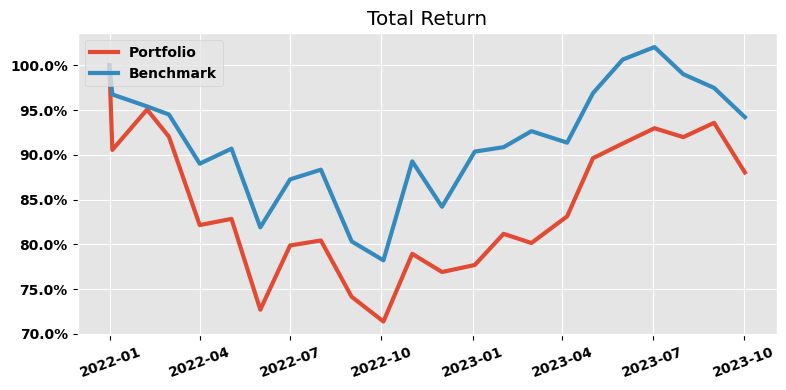

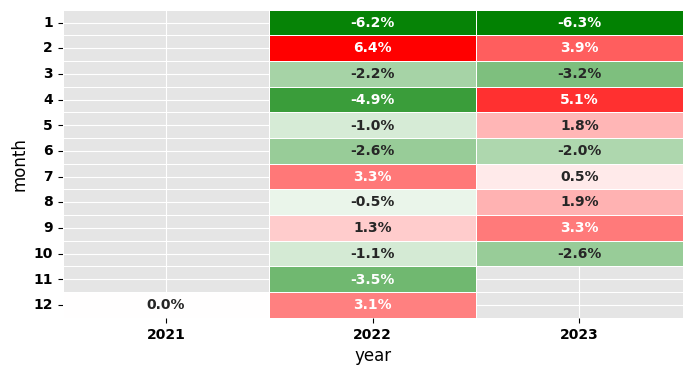

In [95]:
# 績效指標
def perf_cal(df_tr, name_1, name_2):
    status = {}
    status['最大回撤'] = -((df_tr[name_1].cummax() - df_tr[name_1])/df_tr[name_1].cummax()).max()
    status['累積報酬'] = [df_tr[name_1].iloc[-1]]
    status['年化報酬'] = [(df_tr[name_1].iloc[-1] ** (12/len(df_tr))-1)]
    std = df_tr[name_2].std() * np.sqrt(12)
    status['Sharpe Ratio'] = status['年化報酬'] / std
    status = pd.DataFrame(status).transpose()
    status.columns = [name_1]
    return status

# 累積報酬圖
def plot_total_return(df_portfolio_tr,df_benchmark_tr, name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_portfolio_tr.index, df_portfolio_tr['Portfolio Total Return'], label='Portfolio', linewidth=3)
    ax.plot(df_benchmark_tr.index, df_benchmark_tr['Benchmark Total Return'], label='Benchmark', linewidth=3)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.legend(loc='upper left')
    plt.title('Total Return')
    plt.xticks(rotation=20)
    plt.tight_layout()

# 月度勝率圖
def plot_monthly_return(df_portfolio_tr, df_benchmark_tr):
    df_portfolio_tr['year'] = df_portfolio_tr.index.year
    df_portfolio_tr['month'] = df_portfolio_tr.index.month
    df_benchmark_tr['year'] = df_benchmark_tr.index.year
    df_benchmark_tr['month'] = df_benchmark_tr.index.month
    rt_pivot_strategy = df_portfolio_tr.pivot(index='year', columns='month', values='Portfolio Return')
    rt_pivot_benchmark = df_benchmark_tr.pivot(index='year', columns='month', values='Benchmark Return')
    rt_pivot_excess = rt_pivot_strategy - rt_pivot_benchmark

    cmap1= LinearSegmentedColormap.from_list("custom", [(0, "green"), (0.5, "white"), (1, "red")])
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(rt_pivot_excess.T,annot=True, xticklabels= True, yticklabels= True, cmap=cmap1, center=0, fmt='.1%', cbar=False, linewidths=0.5)
    plt.yticks(rotation=0)


# 呼叫績效呈現函式
plot_total_return(df_portfolio_tr,df_benchmark_tr, 'Portfolio_1')
plot_monthly_return(df_portfolio_tr, df_benchmark_tr)
portfolio_perf = perf_cal(df_portfolio_tr, 'Portfolio Total Return','Portfolio Return')
benchmark_perf = perf_cal(df_benchmark_tr, 'Benchmark Total Return','Benchmark Return')
summary_perf = pd.concat([portfolio_perf,benchmark_perf],axis=1)
summary_perf